# Title: DM1590 Final Project Template

### Authors:
Huanchen Cai, Elin Granstedt, Linnéa Gustafsson, Filippa Leuckfeld


# Background and Motivation

### **Predict music popularity**: how likely is a song to get popular? 

Our problem is to predict whether or not a song will get popular today, based on the features available in the Spotify API via a Kaggle.com dataset.


- By popularity we mean the **popularity lately**, not how popular a song has been through history. 
- To simplify the problem we decided to divide the popularity rating between 0-100 into two classes: **either '*not popular*' or '*popular*'** (meaning a **binary classifier** problem).
- We knew from the beginning that this was going to be a very **hard problem**. Therefore, the nature of the problem is somewhat more **investigative**, that is we dig deeper into **which features are correlated with the popularity** and **to which extent we actually could make a prediction** from the data that we have.

### Why is this problem interesting and important?
To create a hit song is not an easy task. Therefore, we found it interesting to dive into if there is a way to use machine learning as a part of this process. Even though it's not an easy task, and that our dataset have limited features, we wanted to investigate if we could find any trends in the available features in relation to the popularity.

If this problem would be solved there would be a lot of use for the solution, but since creating music is a creative process where the qualities often are very abstract, we had no expectations for the results of this project.

Spotify is one of the most successful media technology companies. Companies like Spotify have a great use of being able to decide whether a song is going to be popular among their users or not.

# Dataset

### ***Spotify Dataset 1921-2020, 160k+ tracks***: 
### https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

The data features we use include:

**Numerical**

- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.	

- **duration_ms**: The duration of the track in milliseconds.	

- **energy**: A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.

- **instrumentalness**: Predicts whether a track contains no vocals.

- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

- **loudness**: The overall loudness of a track in decibels (dB).

- **popularity**: The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

- **speechiness**: Detects the presence of spoken words in a track.

- **tempo**: The overall estimated tempo of a track in beats per minute (BPM).

- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.

- **year**: Release date.



**Categorical**

- **key**: The key the track is in.



**Dummy**

- **explicit**: Whether or not the episode has explicit content.

- **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived.


### More about the popularity feature

The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently.

# Methodology

We have followed the machine learning pipeline, where we above have defined the problem and found the dataset which to use for it.

Below, we will continue with the following steps from the pipeline:
- Partition data into training and testing
- Extract features from the training dataset
- Train models on the training dataset
- Evaluate models on the testing dataset

---

# 1. Load, Partition and Present Data
Here we load and clean the dataset and then divide it into training and testing data. We came to learn that we needed to put a lot of time into this part of the project since we had much to consider when it comes to how to partition and scale the data. The things we spent most time on was how to split the popularity feature, and how to treat how the music changes over the years. We also import some libraries. In addition, we set the theme of the plots.  We also look into what the data is by showing some plots.

### 1.1 Import and Install Libraries

In [ ]:
#@title
# Install third part libraries
% pip install boruta
% pip install adjustText

# ----- Import libraries used in multiple cells -----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import warnings; warnings.filterwarnings("ignore") # Removes unimportant warning messages

# sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Tensorflow Keras imports
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping

### 1.2 Set Theme

In [ ]:
#@title
# Set theme of plots
sns.set_theme(style='darkgrid', palette='husl', font='monospace')
title_size = 20

# Set up itertools palette
palette = itertools.cycle(sns.color_palette('Set2'))

# Set theme cmap
cm_theme = sns.diverging_palette(254, 5, l=63, s=100, n=1000)

### 1.3 Load and Clean Dataset

In [ ]:
#@title
# ----- Load dataset, remove duplicates and drop irrelevant features -----
spotify_dataset = pd.read_csv('data.csv',sep=',',header=0)  # Load

# Remove duplicates
duplicates = spotify_dataset.iloc[spotify_dataset.duplicated(subset=['artists', 'name'], keep = 'first').to_numpy()].index.to_numpy()
spotify_dataset = spotify_dataset.drop(duplicates).reset_index()

# Drop irrelevant features
spotify_dataset = spotify_dataset.drop(['id', 'artists', 'name', 'release_date','index'], axis=1)

#### 1.3.1 Presenting the Data: Features over Popularity
Here we take a look on how the popularity means are changing over the different features.

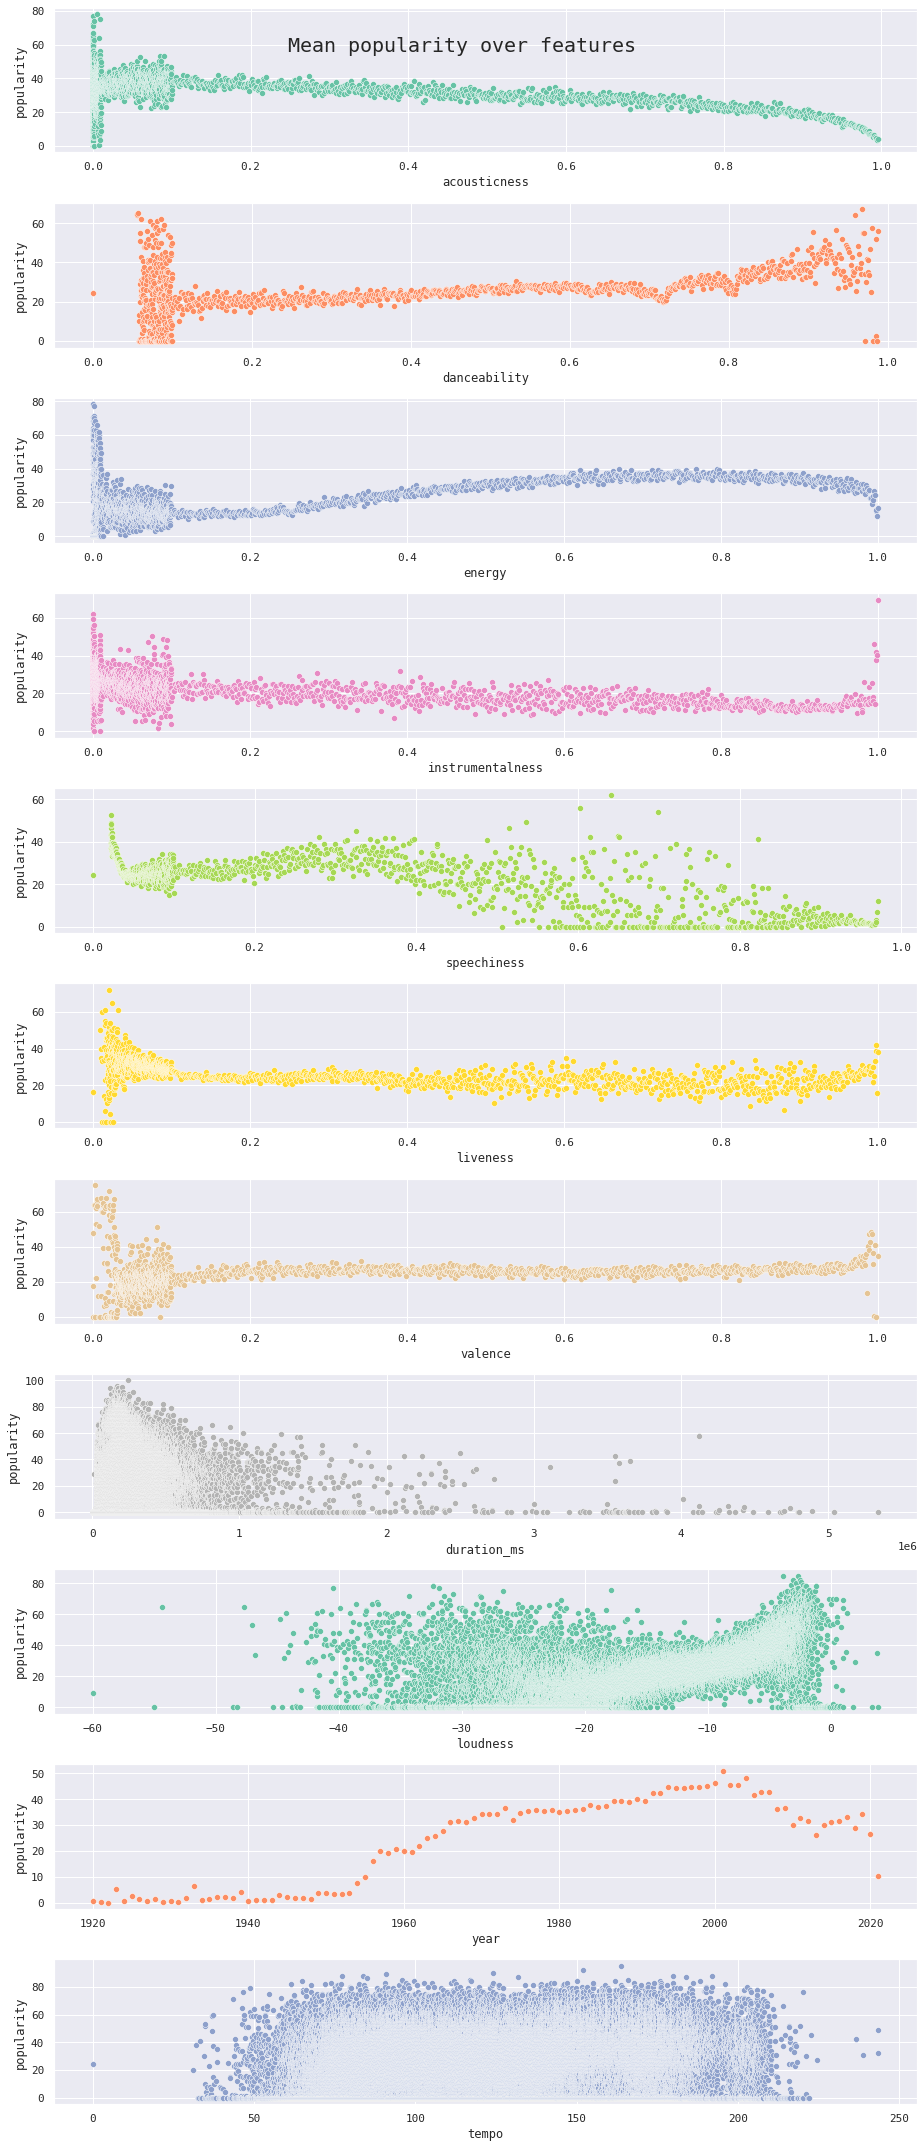

In [ ]:
#@title
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
            'speechiness', 'liveness', 'valence','duration_ms', 'loudness', 
            'year', 'tempo']

# Set up figure, title and labels
fig, ax = plt.subplots(len(features), figsize=(13, 30))
fig.tight_layout(pad=20)
fig.suptitle('Mean popularity over features', size=title_size)


# Plot features
i = 0
for feature in features:
    x = spotify_dataset.groupby(feature)['popularity'].mean().to_frame().reset_index()
    sns.scatterplot(x = x[feature], y = x['popularity'], ax=ax[i], color=next(palette))
    plt.tight_layout()
    i += 1

plt.show()  

We can see that as for example **energy**, **danceability**, **loudness** and **year** increases, the mean of the popularity will also increase.

And when **acousticness**, **instrumentalness** and **speechiness** increases, popularity decreases.

#### 1.3.2 Split Popularity into Two Classes

To train a model against popularity it is important that we know how the popularity feature is distributed. Here we create a box plot to show the distibution of the popularity feature.

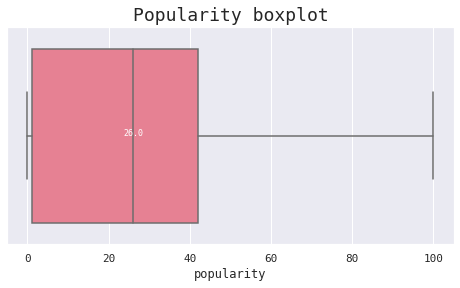

In [ ]:
#@title
# Plot boxplot of popularity distribution
plt.figure(figsize=(8,4))
ax = sns.boxplot(x=spotify_dataset['popularity'])
plt.title("Popularity boxplot", size=18) 
median = spotify_dataset['popularity'].median()
ax.text(median, 0,s=median, horizontalalignment='center',size='x-small',color='w')

mean = spotify_dataset['popularity'].mean()

To simplify the problem we decided bin the data into two classes "Not Popular" - 0 and "Popular" - 1. Since the popularity feature is not normally distributed we wanted to investigate what split would be the best. In order to do this we need to calculate datasets with different partitions. Below we have plotted the distribution of the popularity in the different datasets.

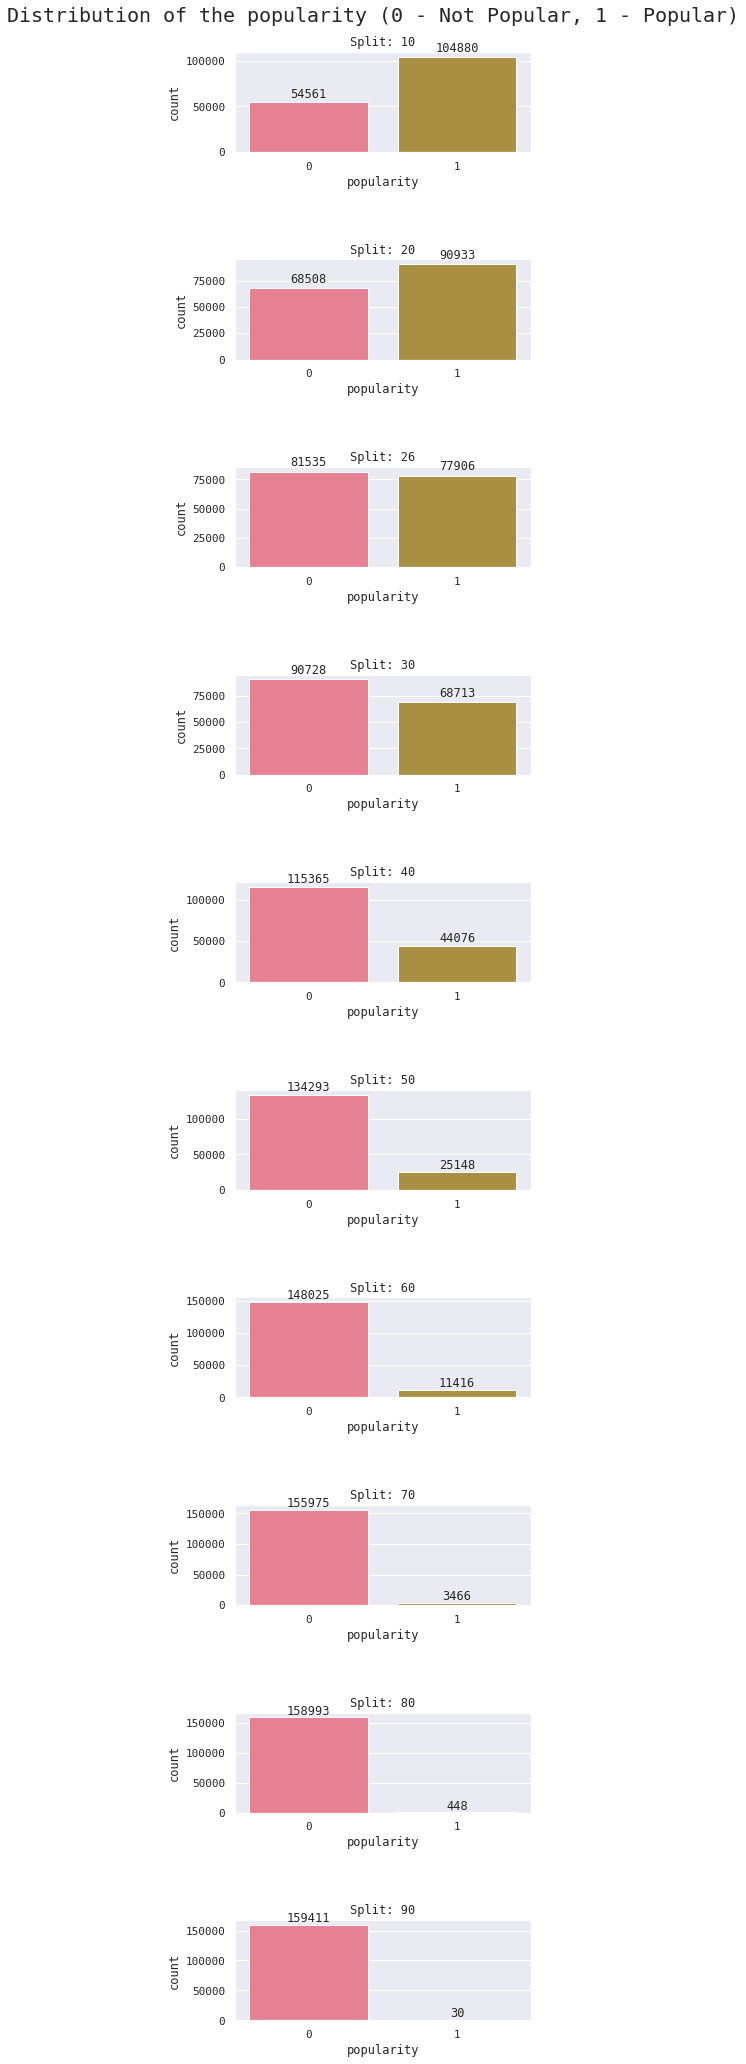

In [ ]:
#@title
# ----- Group popularity from 0-100 to 0 or 1 with different splits -----

# Create dictionary to store datasets for different splits of the popularity classes
datasets = { 'spotify_dataset_10' : None
            , 'spotify_dataset_20' : None
            , 'spotify_dataset_26' : None 
            , 'spotify_dataset_30' : None
            , 'spotify_dataset_40' : None
            , 'spotify_dataset_50' : None
            , 'spotify_dataset_60' : None
            , 'spotify_dataset_70' : None
            , 'spotify_dataset_80' : None 
            , 'spotify_dataset_90' : None }

# Set up plot
fig, ax = plt.subplots(10, figsize=(7, 30))
fig.tight_layout(pad=7)
fig.suptitle('Distribution of the popularity (0 - Not Popular, 1 - Popular)', size=title_size)

# Plot distribution of the data within the different splits
splits = [10,20,26,30,40,50,60,70,80,90]
j = 0
for i in splits:
    datasets['spotify_dataset_{}'.format(i)] = spotify_dataset.copy()
    datasets['spotify_dataset_{}'.format(i)].loc[spotify_dataset['popularity'] <= i, 'popularity'] = 0  # 0 is not popular
    datasets['spotify_dataset_{}'.format(i)].loc[spotify_dataset['popularity'] > i, 'popularity'] = 1  # 1 is popular

    plot = sns.countplot(x=datasets['spotify_dataset_{}'.format(i)]['popularity'], ax=ax[j])  # Create plot
    
    for p in plot.patches:
        height = p.get_height()
        plot.text(p.get_x()+p.get_width()/2., height + 5000, height, ha="center")  # Add amount above bars
    
    ax[j].set_title(('Split: '+ str(i)))  # Title

    j += 1

plt.show()

#### 1.3.3 Distribution of Number of Songs over the Years
In order to being able to partition the data properly, we need to look more into what we are working with. It's for example interesting to see how the data is distributed over the years, so here we dig into that.

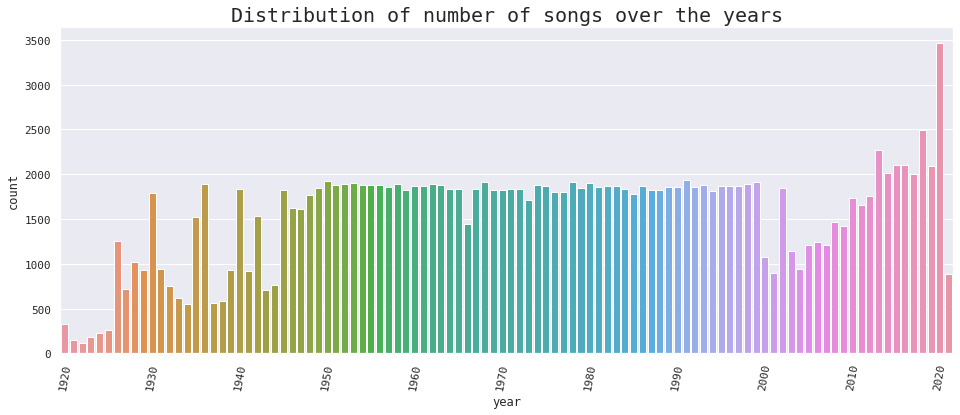

In [ ]:
#@title
year = spotify_dataset['year']  # The 'year' column we're going to plot

fig, ax = plt.subplots(figsize=(16, 6))  # Set up figure
plot = sns.countplot(x=year, ax=ax)  # Create plot

# Reduce number of ticks
new_ticks = [i.get_text() for i in plot.get_xticklabels()]
plt.xticks(range(0, len(new_ticks)+1, 10), new_ticks[::10])

plot.set_xticklabels(plot.get_xticklabels(), rotation=80, horizontalalignment='center')  # Rotate x-axis labels

ax.set_title('Distribution of number of songs over the years', fontsize=title_size)  # Title

plt.show()

We can see that we have a somewhat uneven distribution over the years. This lead us to splitting the data for each year, instead of just splitting the dataset as a whole.

#### 1.3.4 Features over Year
Since we have decided to split the data for each year we also wanted to investigate how the features are changing over time.

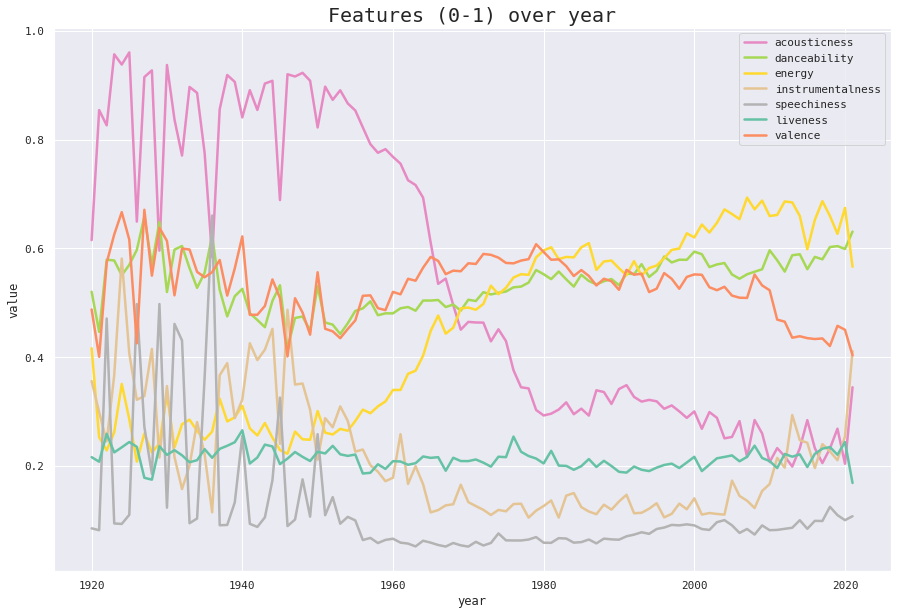

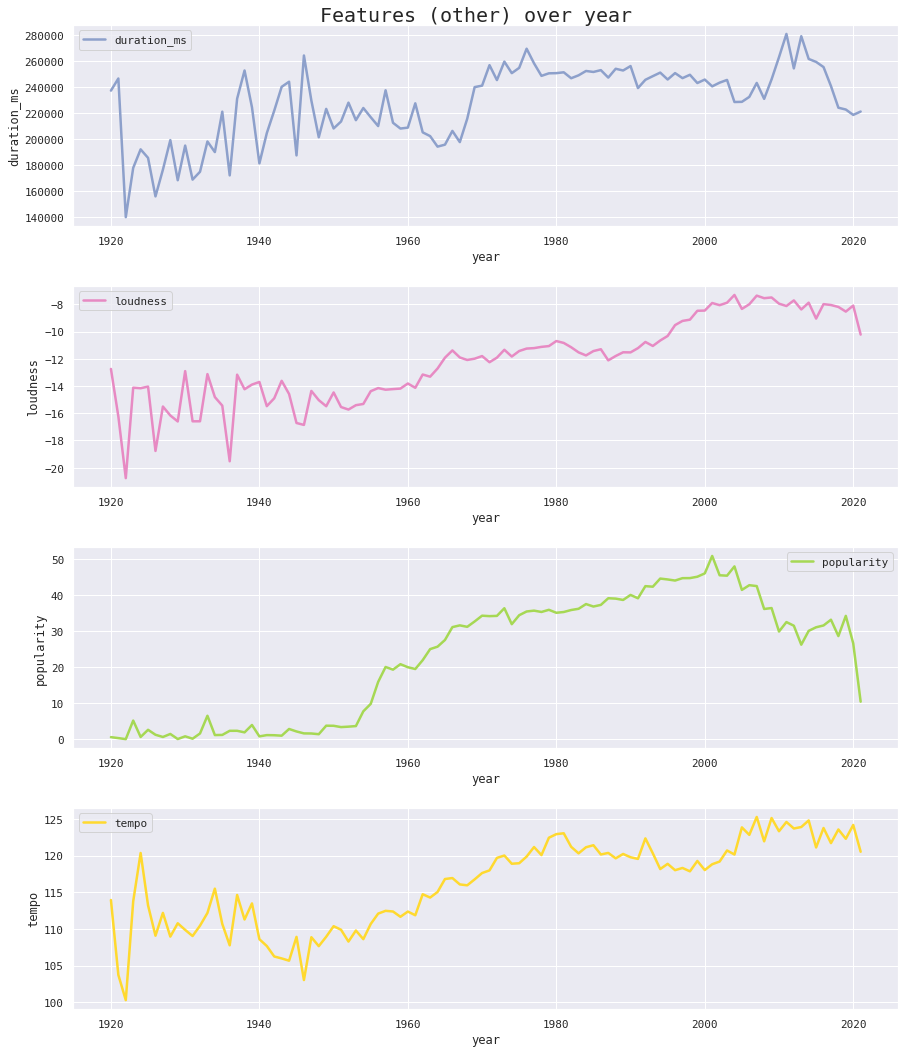

In [ ]:
#@title
# --------------- Features group 1 ---------------

# The features that varies between 0-1 (to be plotted in same plot)
features_0to1 = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                   'speechiness', 'liveness', 'valence']

# Set up figure, title and labels
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Features (0-1) over year', fontsize=title_size)
ax.set_ylabel('value')
ax.set_xlabel('year')

# Plot features
i = 0

for feature in features_0to1:
    x = spotify_dataset.groupby('year')[feature].mean()
    sns.lineplot(x=x.index, y=x, label=feature, color=next(palette), linewidth=2.5)
    i += 1

plt.show()


# --------------- Features group 2 ---------------

# The features that varies between other values (to be plotted in own plots)
features_other = ['duration_ms', 'loudness', 'popularity', 'tempo']

# Set up figure and title
fig, ax = plt.subplots(len(features_other), figsize=(13, 15))
fig.tight_layout(pad=3)
fig.suptitle('Features (other) over year', size=title_size)

# Plot features
i = 0

for feature in features_other:
    x = spotify_dataset.groupby('year')[feature].mean()  # Should we have the scaled or unscaled data here?
    sns.lineplot(x=x.index, y=x, label=feature, color=next(palette), linewidth=2.5, ax=ax[i])
    i += 1

plt.show()

In the plots above we can see that the features are changing a lot over the years. This further highlights that it's important that we have an even split of old and new songs in the training and testing datasets.

### 1.4 Scale and Partition Dataset

We use min max scaler to scale all the data between 0 and 1 so that all the features have the same range. This will be needed later when we run our unsupervised and supervised models especially for PCA and neural network.

Ideally we would have liked to explore this even further and try different scaling methods depending on the algorithm we will use it for. But because of the magnitude of the project we didn't prioritize this.

In [ ]:
#@title
def scale_and_split(df):
  """ Scales the data in df using min-max normalization and splits into training 
  and testing data by year, and returns data partition."""
  mms = MinMaxScaler()  # To transform features with by scaling each feature to between 0-1
  dataset = df.copy()
  features = ['acousticness', 'danceability','energy', 'duration_ms', 
              'instrumentalness', 'valence', 'tempo', 'liveness', 'loudness', 
              'speechiness', 'year', 'mode', 'explicit', 'key']
  dataset[features] = mms.fit_transform(dataset[features])  # Fit with data

  X_train = pd.DataFrame(columns=features, dtype='int')
  X_test = pd.DataFrame(columns=features, dtype='int')
  y_train = pd.Series(name='popularity', dtype='int')
  y_test = pd.Series(name='popularity', dtype='int')

  for _, dataset_year in dataset.groupby('year'):
      X_i, y_i = dataset_year.drop(['popularity'], axis=1), dataset_year['popularity'] # why change to df
      X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.3, random_state=1)
      X_train, X_test = X_train.append(X_train_i), X_test.append(X_test_i)
      y_train, y_test = y_train.append(y_train_i), y_test.append(y_test_i)

  return X_train, X_test, y_train, y_test


# Partition with popularity either 'not popular' (0) or 'popular' (1)
X_train, X_test, y_train_10, y_test_10 = scale_and_split(datasets['spotify_dataset_10'])
_, _, y_train_20, y_test_20 = scale_and_split(datasets['spotify_dataset_20'])
_, _, y_train_26, y_test_26 = scale_and_split(datasets['spotify_dataset_26'])
_, _, y_train_30, y_test_30 = scale_and_split(datasets['spotify_dataset_30'])
_, _, y_train_40, y_test_40 = scale_and_split(datasets['spotify_dataset_40'])
_, _, y_train_50, y_test_50 = scale_and_split(datasets['spotify_dataset_50'])
_, _, y_train_60, y_test_60 = scale_and_split(datasets['spotify_dataset_60'])
_, _, y_train_70, y_test_70 = scale_and_split(datasets['spotify_dataset_70'])
_, _, y_train_80, y_test_80 = scale_and_split(datasets['spotify_dataset_80'])
_, _, y_train_90, y_test_90 = scale_and_split(datasets['spotify_dataset_90'])

In [ ]:
#@title
def under_sample(X_train, y_train):
  """ Undersample training data """
  # Combine training data for resampling
  train_data = pd.concat([X_train, y_train], axis=1)

  # Separate classes
  low = train_data[train_data.popularity==0]
  high = train_data[train_data.popularity==1]

  # Undersample
  low_undersampled = resample(low, replace=True, n_samples=len(high), random_state=27) 
  undersampled = pd.concat([low_undersampled, high]).sample(frac=1)
  X_train_down = undersampled.drop(['popularity'], axis=1)
  y_train_down = pd.Series(undersampled['popularity'], name='popularity', dtype='int')

  return X_train_down, y_train_down


# Undersampled data
X_train_down, y_train_down = under_sample(X_train, y_train_50)  # Based on 50 split

We chose to go with only the popularity split by 50 for the undersampled data in order to limit the number of iterations in the project, and also because splitting popularity by the middle of the scale made sense for where to draw a line for the two different groups, more about this later in the report.

# 2. Extract Features from Training Dataset/Unsupervised Learning

### 2.1 Scatter Matrix
Here we investigate the relationship between each pair of dimensions, and also check out the distribution of the data within each dimension.

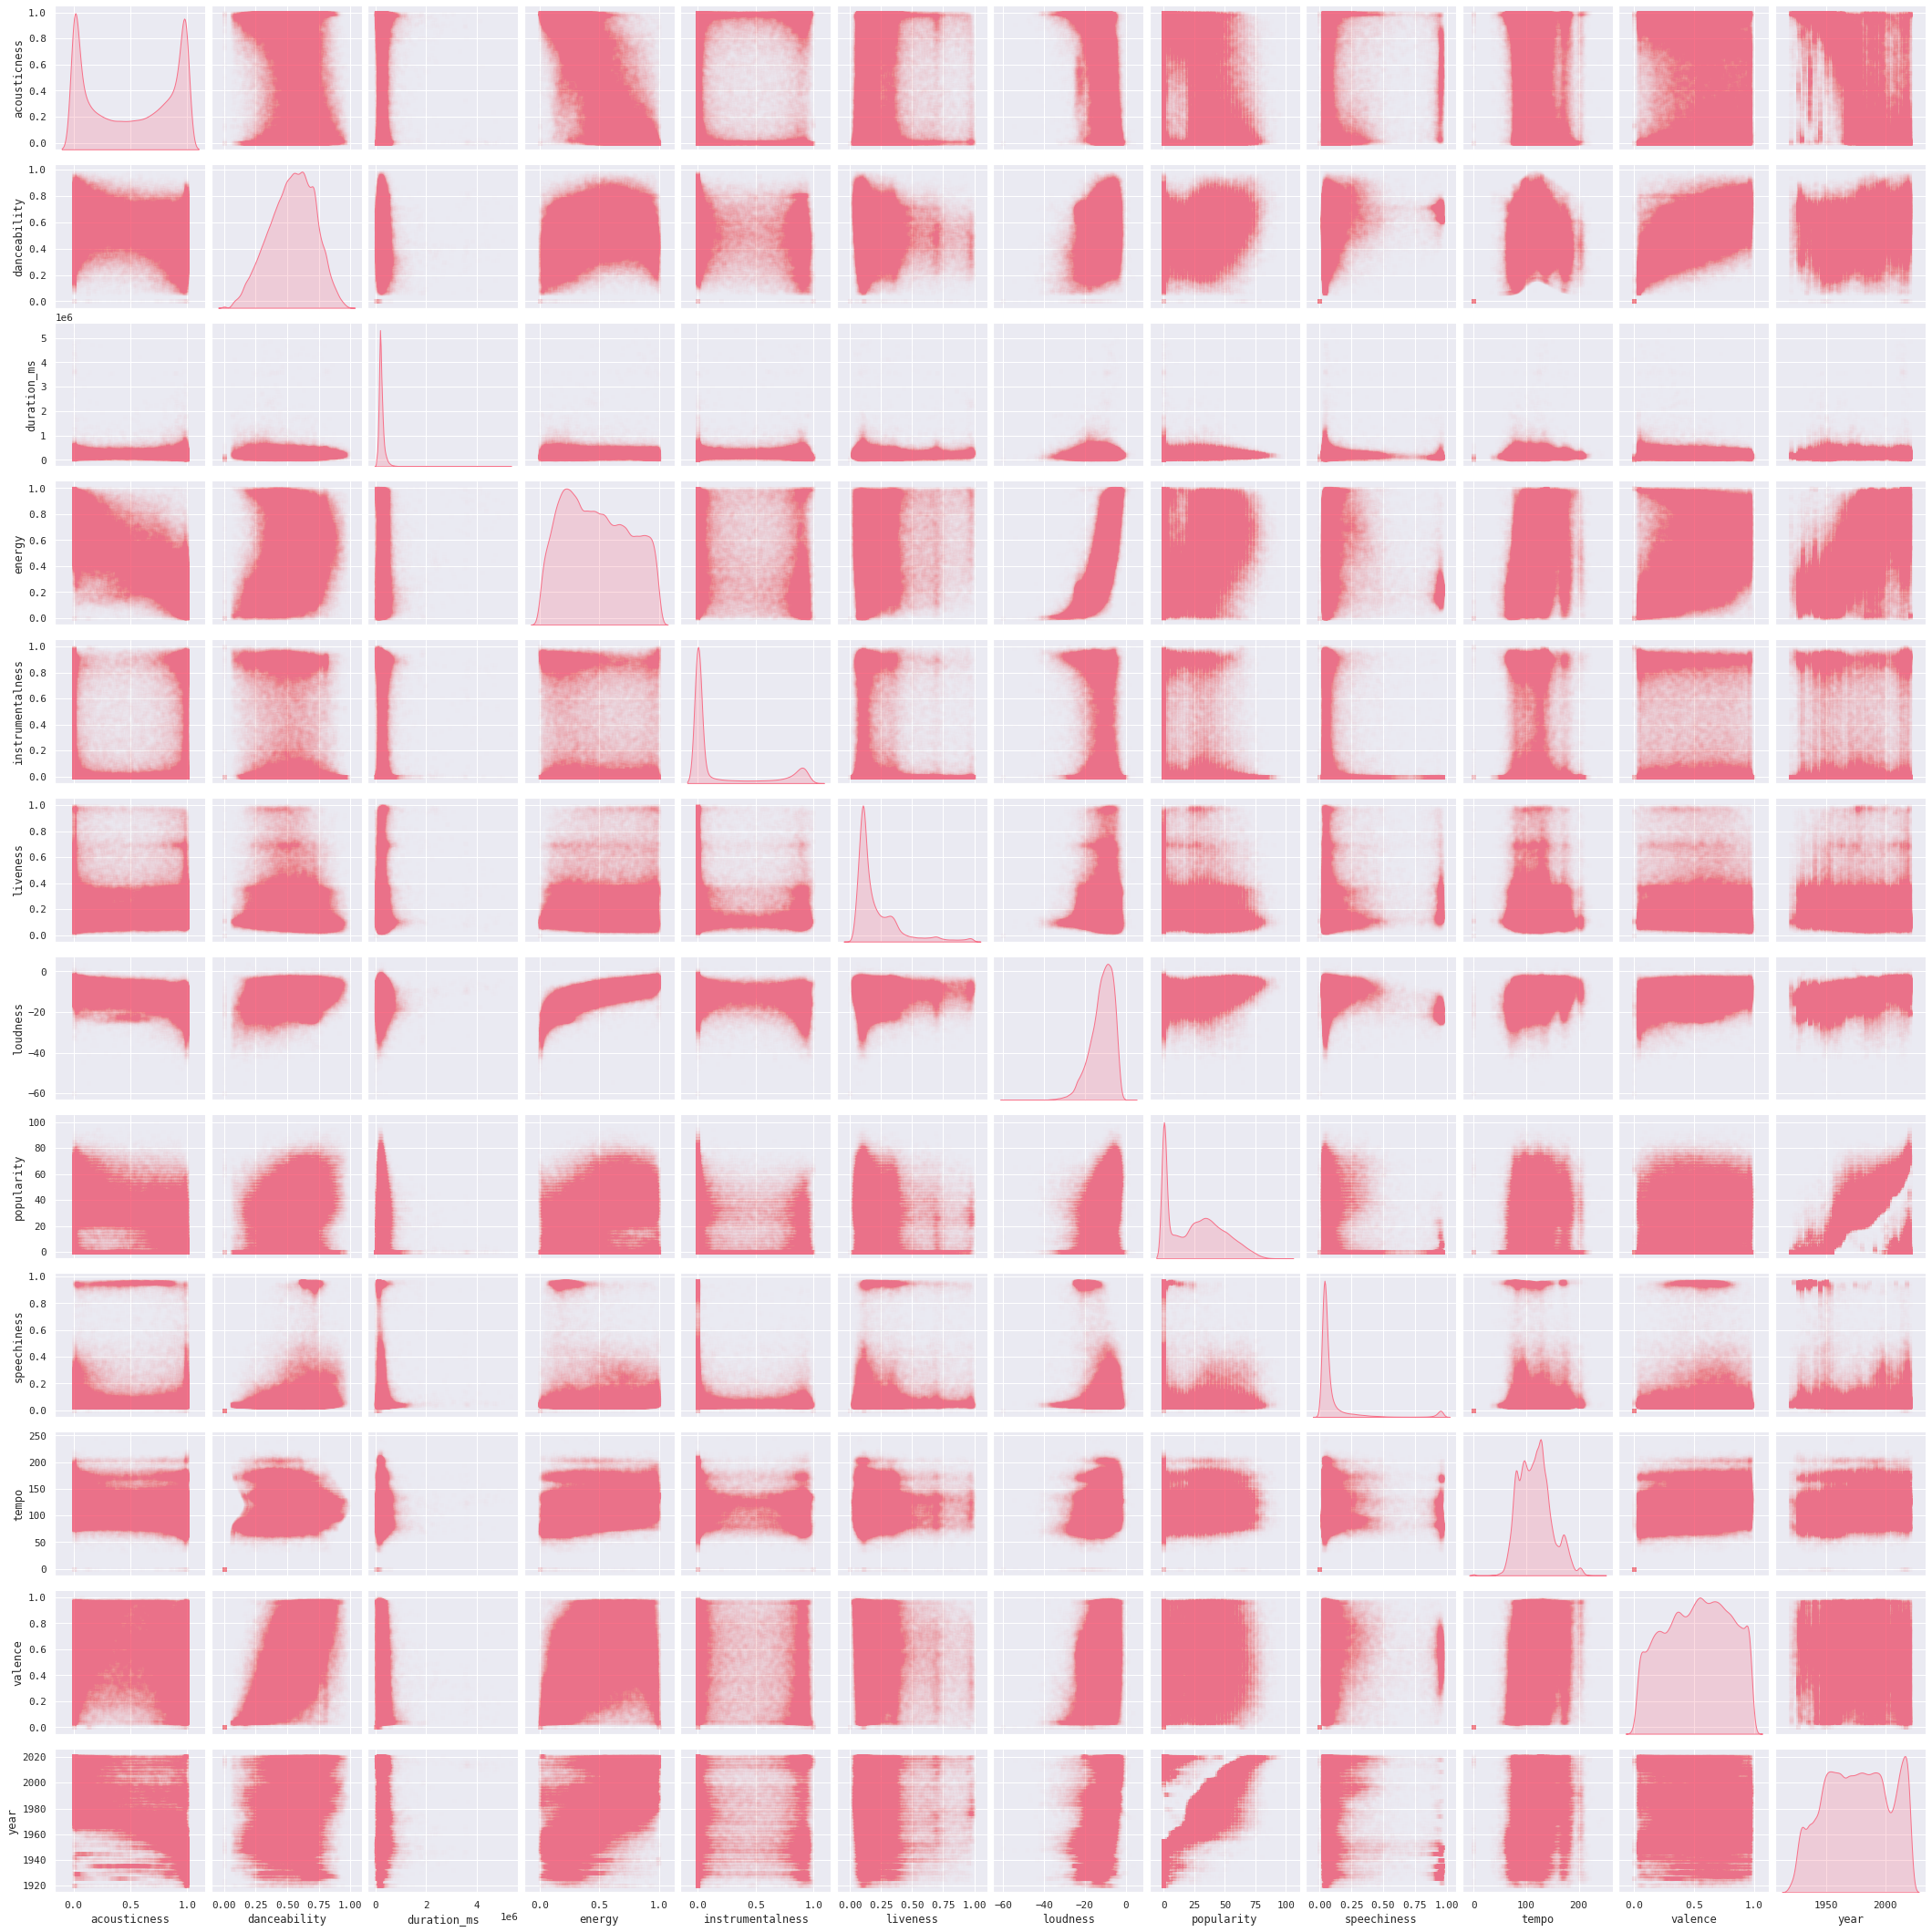

In [ ]:
#@title
# The data to plot
data = spotify_dataset.drop(['explicit', 'key', 'mode'], axis=1)  # Drops the categorical/dummy features

g = sns.pairplot(data, diag_kind='kde', plot_kws={'alpha':0.002})  # Create plot
 
plt.show()

From the plot we can again distinguish positive correlations with the popularity for **year**, **energy**, **loudness** and **danceability**, and negative for **acousticness**, **instrumentalness** and **speechiness**.

### 2.2 Spearman Correlation
Here we compute the Spearman correlation coefficients and then take a closer look on the coefficients connected to popularity.

The reason we use Spearman (and not Pearson) is that we are dealing with ordinal data, and not only continuous and normally distributed data. Since Spearman correlation can evaluate a monotonic relationship between two variables we did not include key, mode and explicit in the calculations.

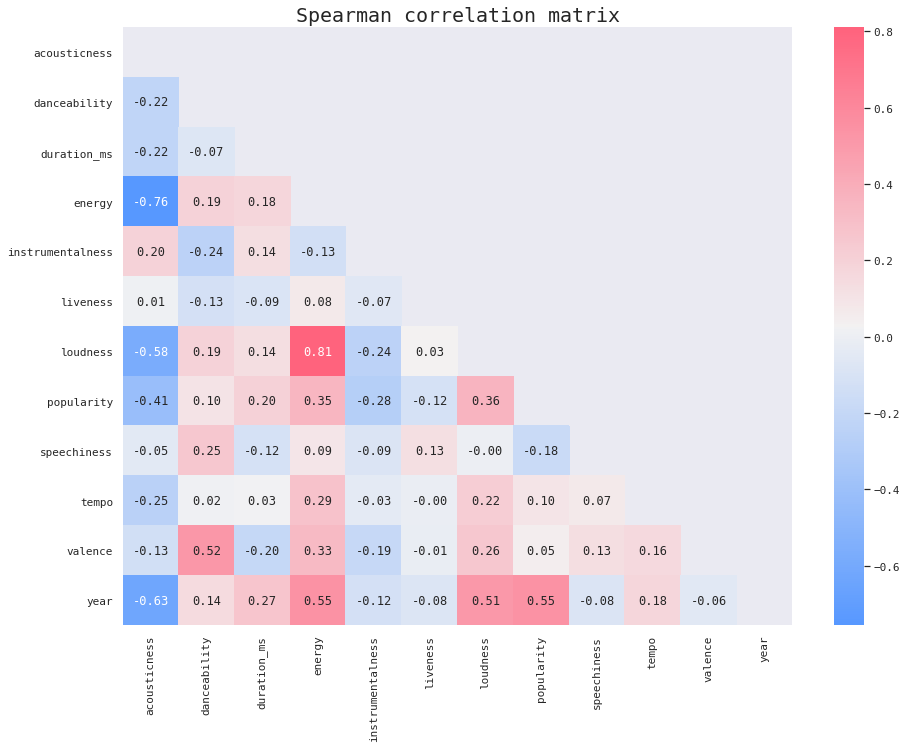

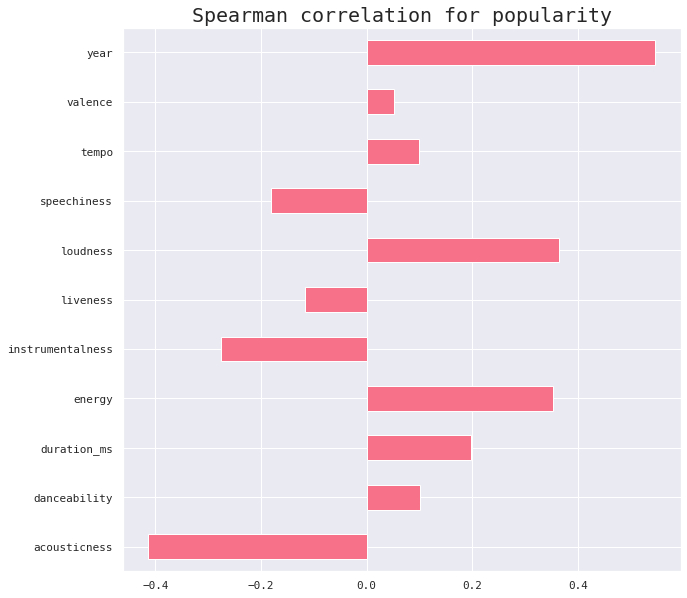

In [ ]:
#@title
# ----- Plot all correlations -----
# Compute and plot Spearman correlation coefficients
corr = spotify_dataset.drop(['explicit', 'key', 'mode'], axis=1).corr(method='spearman')
matrix = np.triu(corr)  # Get correlation matrix
plt.figure(figsize=(15, 11))  # Set up figure
sns.heatmap(corr, annot=True, mask=matrix, cmap=cm_theme, fmt='.2f')  # Create plot
plt.title('Spearman correlation matrix', fontsize=title_size)
plt.show()


# ----- Plot popularity correlations -----
# The correlations with popularity we're going to plot
corr_popularity = corr['popularity'].drop(labels='popularity')

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))  
corr_popularity.plot(kind='barh')
ax.set_title('Spearman correlation for popularity', fontsize=title_size)  # Title
plt.show()

From the Spearman correlation coefficients we can again confirm the findings from the popularity mean over feature scatter plots we saw earlier. **Year**, **loudness** and **energy** again have relatively strong positive correlations; and **acousticness**, **instrumentalness** and **speechiness** have relatively strong negative correlations.

###  2.3 Boruta Feature Selection

We want alternative datasets with reduced dimensionality, and are using feature selection to choose which features to keep. This will possibly help prevent noise data from disturbing the supervised models. 

Boruta is a more advanced type of feature selection, where we use a Random Forest classifier to find the relevant features. The difference between Boruta and other feature selection methods is that Boruta is keeping all relevant features, when others usually minimize the number of kept features as much as possible.


In [ ]:
#@title
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Define Boruta feature selection method
feat_selector = BorutaPy(RandomForestClassifier(n_jobs=-1, class_weight='balanced', criterion='entropy', max_depth=8), n_estimators='auto', verbose=4, random_state=1)

# Find all relevant features
feat_selector.fit(X_train.values, y_train_26.values)

cols_selected = feat_selector.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	2


In [ ]:
print("The boruta selected features are:", end=" ")
print(*cols_selected_boruta, sep=", ")

The boruta selected features are: acousticness, danceability, energy, duration_ms, instrumentalness, valence, tempo, liveness, loudness, speechiness, year, explicit


###  2.4 SelectKBest Feature Selection

SelectKBest is another feature selection method that select features according to the k highest scores. We chose k = 12 to get an equal amount of features as boruta.

In [ ]:
#@title
from sklearn.feature_selection import SelectKBest, chi2

columns = X_train.columns

selector = SelectKBest(chi2, k=12)  # Create feature selector with five features
selector.fit_transform(X_train, y_train_26)  # Fit to X_train and y_train
sup = selector.get_support()  # Get mask of the features selected
selectK_features = X_train.iloc[:,sup].columns.values.tolist()
print("The Kbest selected features are:", end=" ")
print(*selectK_features, sep=", ")

The Kbest selected features are: acousticness, danceability, energy, duration_ms, instrumentalness, valence, tempo, liveness, loudness, speechiness, year, explicit


In [ ]:
# Creating new dataset with only the selected features from boruta and Kbest
X_train_selected, X_test_selected = X_train[selectK_features], X_test[selectK_features]

### 2.5 Principal Component Analysis
Here we perform PCA to further look at which dimensions could be the most important. We again removed the categorical data since PCA assumes normal distribution, and these are not at all close to that.

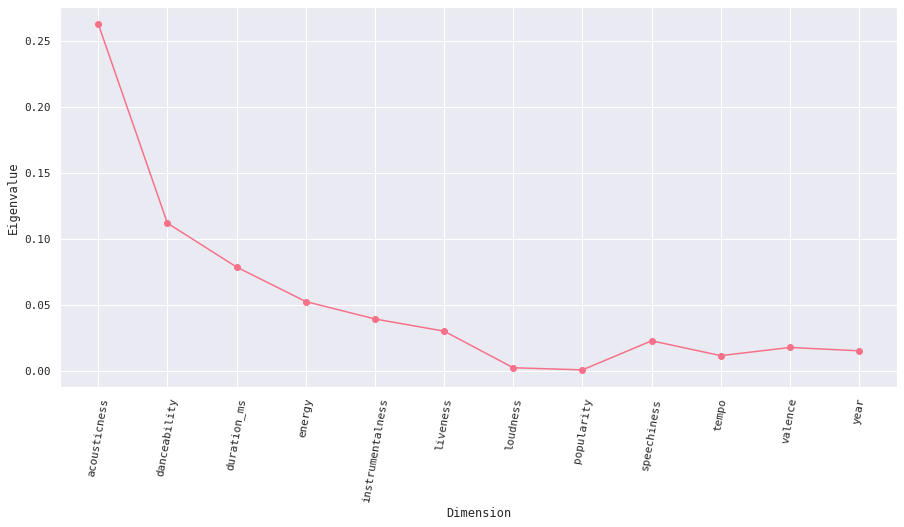

In [ ]:
#@title
# ----- Plot eigenvalues of covariance matrix -----

# Get transformed data
dataset = spotify_dataset.drop(['key', 'mode', 'explicit'], axis=1)
dataset_PCA = pd.DataFrame(MinMaxScaler().fit_transform(dataset))

# Covariance matrix
C = dataset_PCA.cov()

# Eigenvalues and eigenvectors
L, Q = np.linalg.eig(C)

# Labels of the dimensions
dim_lbls = dataset.columns.values

# Create plot
plt.figure(figsize=(15, 7))
plt.plot(L, 'o-')
plt.xticks(ticks=range(L.size), 
           labels=dim_lbls, 
           rotation=80)  # Add labels to x-axis
plt.ylabel("Eigenvalue")
plt.xlabel("Dimension")
plt.show()

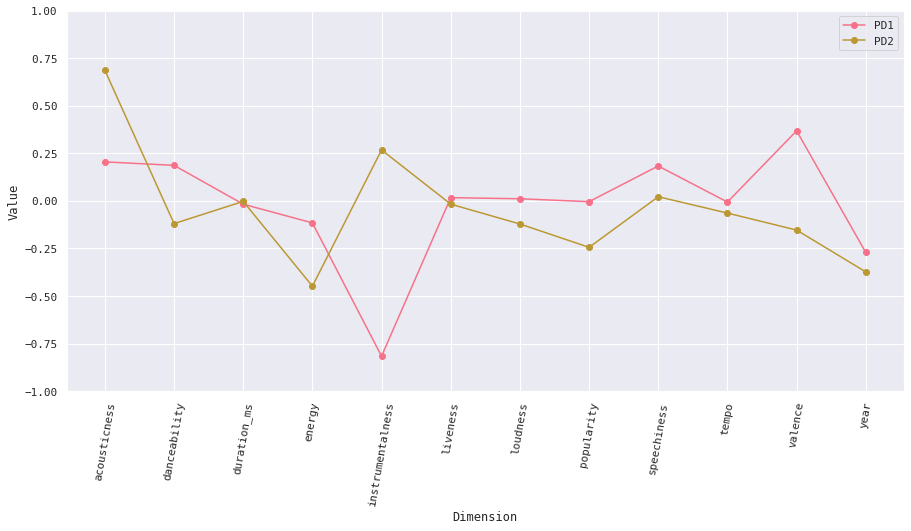

In [ ]:
#@title
# ---------- Plot the two eigenvectors with the largest eigenvalues ----------

# Get the index of the two largest eigenvectors and create a new array
largest_eigenvectors = Q[:,np.argsort(L)[-2:]]

# Get indexes of PDs
pd_indexes = np.argsort(L)[-2:]
pd1_index, pd2_index = pd_indexes[1], pd_indexes[0]

# Plot eigenvectors/principal directions
plt.figure(figsize=(15, 7))
plt.plot(largest_eigenvectors[:, pd1_index], 'o-', label='PD1')
plt.plot(largest_eigenvectors[:, pd2_index], 'o-', label='PD2')
plt.ylabel('Value')
plt.xlabel("Dimension")
plt.xticks(ticks=range(L.size), 
           labels=dim_lbls, 
           rotation=80)
plt.ylim(-1, 1)
plt.legend()
plt.show()

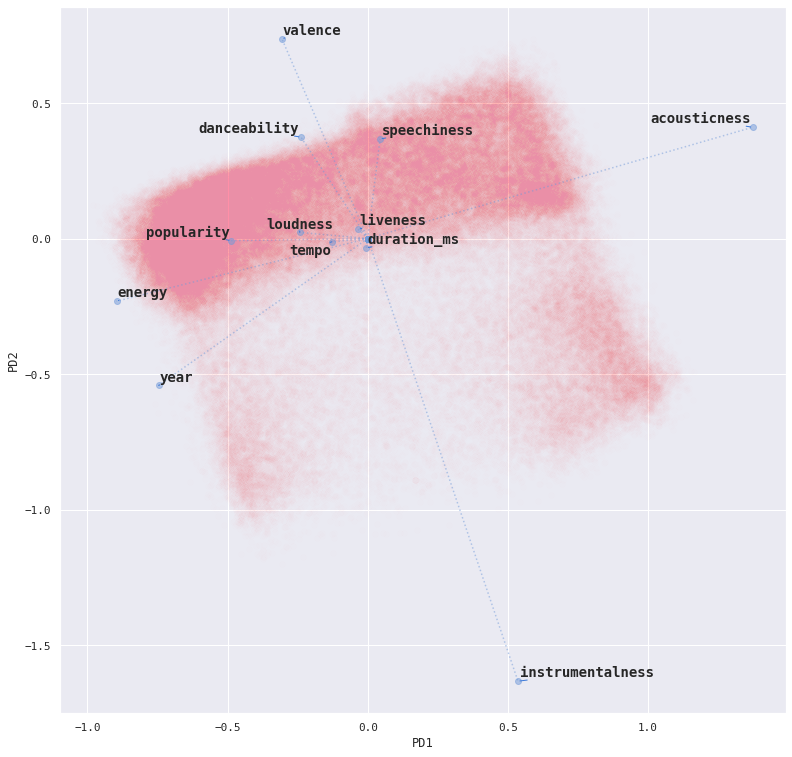

In [ ]:
#@title
# ----- Make scatter plot of projected mean-centered observations onto the two eigenvectors -----
from adjustText import adjust_text

x = dataset_PCA.values

# Compute the mean vector of the entire dataset
mu_mean = np.array(np.mean(dataset_PCA))

# For each observation x_n, compute y_n
y = np.dot(Q.T, (x-mu_mean).T).T

# Plot coordinates of the dimensions of y that correspond to our eigenvectors above
pd1 = y[:,pd1_index]  # principal direction 1
pd2 = y[:,pd2_index]  # principal direction 2
plt.figure(figsize=(13, 13))
plt.scatter(pd1, pd2, alpha=0.002, c='#ff8fa7')
plt.xlabel('PD1'); plt.ylabel('PD2')

# Create lines from the origin to the point ([q_1]d, [q_2]d) for each dimension d 
scalar = 2 # To scale up lines with

for i in range(len(L)):
    # Plot line
    plt.plot([0, scalar * Q[i,pd1_index]], 
             [0, scalar * Q[i,pd2_index]], 
             c='#719ad9', 
             marker='o', 
             ls='dotted',
             alpha=0.5)

# Create dimension text labels
texts = [plt.text(scalar * Q[i,pd1_index], 
                  scalar * Q[i,pd2_index], 
                  '%s' %dim_lbls[i], 
                  fontsize=14, weight='bold') for i in range(len(L))]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#3d7ad9'))

plt.show()

From the PCA we can as well confirm our earlier findings. Since we don't have perfect normal distribution for the features we kept we have to be careful with the conclusions from this analysis, but the results seem reasonable when compared to previous discoveries: especially for **energy**, **year**, **loudness** and **acousticness**.

# 3. Train Models on Training Dataset/Supervised Learning

### 3.0 Performance Function and Accuracy Plot

**Performance Function**

This function is used to see how each model performs. It returns the following:

- *accuracy* (closeness of computations to the true values)
- *accuracy for choosing at random* (for comparison)
- *accuracy for always choosing 'not popular'* (for comparison)
- *precision* (accuracy of positive predictions)
- *recall* (fraction of positives that were correctly identified)
- *f1-score* (a weighted harmonic mean of precision and recall; should be used to compare classifier models, not global accuracy)
- *support* (number of occurrences of the class in the specified dataset)

For all the parameters, except support, the best score is 1.0 and the worst score is 0.0. Support will be an integer where we want the counts to be balanced between the different classes.

**Accuracy Plot**

A function that plots the accuracies of the models going through different splits of the popularity feature.

In [ ]:
#@title
def performance(model, data_type, y_test, y_pred):
  """Returns performance parameters, given the model trained: MAE, MSE, RMSE, R2, Accuracy"""
  acc = sum(y_test == y_pred) / len(y_pred)  # Accuracy
  mse = mean_squared_error(y_test, y_pred)  # Mean Square Error
  rmse = np.sqrt(mse)  # Root Mean Square Error
  mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
  rs = r2_score(y_test, y_pred)  # R^2 (coefficient of determination) Regression Score

  # Accuracy to compare with:
  y_random = np.array([random.randint(0, 100) for p in range(0, len(y_pred))])
  acc_random = sum(y_test == y_random) / len(y_random)  # Accuracy of random prediction
  acc_not_popular = sum(y_test == 0) / len(y_test)  # Accuracy of always choosing 'Not Popular'

  class_report =  classification_report(y_test, y_pred, labels = [0,1], output_dict = True)

  df0 = pd.DataFrame({
    'Model' : model,
    'Datatype' : data_type,
    'Accuracy' : class_report['accuracy'],
    'Acc (Random)' : acc_random,
    'Acc (Not Pop.)' : acc_not_popular,
    'Label': 0,
    'Precision': class_report['0']['precision'],
    'Recall' : class_report['0']['recall'],
    'f1-score' : class_report['0']['f1-score'],
    'support' : class_report['0']['support']
    }, index=[0])
  
  df1 = pd.DataFrame({
    'Model' : model,
    'Datatype' : data_type,
    'Accuracy' : class_report['accuracy'],   
    'Acc (Random)' : acc_random,
    'Acc (Not Pop.)' : acc_not_popular,
    'Label': 1,
    'Precision': class_report['1']['precision'],
    'Recall' : class_report['1']['recall'],
    'f1-score' : class_report['1']['f1-score'],
    'support' : class_report['1']['support']
    }, index=[0])
  
  model_performance = pd.concat([df0,df1])
  return model_performance

In [ ]:
#@title
# Accuracy plot to investigate how the models performs on the different splits
def accuracy_plot(accuracy):
  # Create plot
  K = [10,20,26,30,40,50,60,70,80,90]
  fig, ax = plt.subplots(figsize =(10, 5))
  ax.set(ylabel="Accuracy", xlabel="Popularity split")
  ax.set_title(label="Accuracy over popularity split", fontsize=title_size)
  sns.lineplot(x=K, y=accuracy, label="Accuracy", linewidth=2.5)
  plt.legend()
  plt.show()

### 3.1 Naive Bayes Classifier
The naive Bayes classifier is a simple type of classifier that makes the naive assumption that the features are independent. Because of this, our expectations was not to get great results from this classifier, but we found it interesting to compare the other models to it.

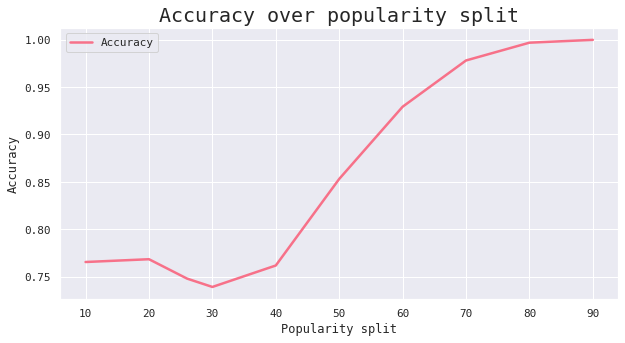

In [ ]:
#@title
def naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train, y_test, data_type='-'):
  gnb = GaussianNB() 
  gnb.fit(X_train[columns_numerical], y_train) 
  log_p_n = gnb.predict_log_proba(X_test[columns_numerical]) 

  cnb = CategoricalNB() 
  cnb.fit(X_train[columns_categorical], y_train) 
  log_p_c = cnb.predict_log_proba(X_test[columns_categorical]) 

  probpopularity0 = sum(y_train==0)/len(y_train)  #!!Fixa detta

  log_p = log_p_c + log_p_n + np.log([probpopularity0,1-probpopularity0])

  y_pred_NB = np.argmax(log_p, axis=1)  # Returns which class has largest log prob for each sample in test data

  performance_NB = performance('Naive Bayes', data_type, y_test, y_pred_NB)
  accuracy = sum(y_test == y_pred_NB) / len(y_pred_NB)

  return performance_NB, accuracy

# The different groups of features: numerical, categorical and selected features from SelectKBest and Boruta
columns_numerical = ['acousticness', 'danceability','energy', 'duration_ms', 'instrumentalness', 'valence', 'tempo', 'liveness', 'loudness', 'speechiness', 'year']
columns_categorical = ['mode', 'explicit', 'key']

# Train model on different splits
performance_NB_10, acc_10 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_10, y_test_10, 'Split: 10')
performance_NB_20, acc_20 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_20, y_test_20, 'Split: 20')
performance_NB_26, acc_26 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_26, y_test_26, 'Median')
performance_NB_30, acc_30 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_30, y_test_30, 'Split: 30')
performance_NB_40, acc_40 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_40, y_test_40, 'Split: 40')
performance_NB_50, acc_50 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_50, y_test_50, 'Split: 50')
performance_NB_60, acc_60 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_60, y_test_60, 'Split: 60')
performance_NB_70, acc_70 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_70, y_test_70, 'Split: 70')
performance_NB_80, acc_80 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_80, y_test_80, 'Split: 80')
performance_NB_90, acc_90 = naivebayes(columns_numerical, columns_categorical, X_train, X_test, y_train_90, y_test_90, 'Split: 90')

# Create plot
accuracy = [acc_10,
            acc_20,
            acc_26,
            acc_30,
            acc_40,
            acc_50,
            acc_60,
            acc_70,
            acc_80,
            acc_90]

accuracy_plot(accuracy)

### 3.2 Decision Tree
The decision tree algorithm is a flowchart-like tree structure where an internal node represents a feature, the branch represents a decision rule, and each leaf node represents the outcome. Essentially, they learn a hierarchy of if/else questions, leadning to a decision. 

(C. Müller, A. & Guido, S., Intro to Machine Learning with Python, p. 70)

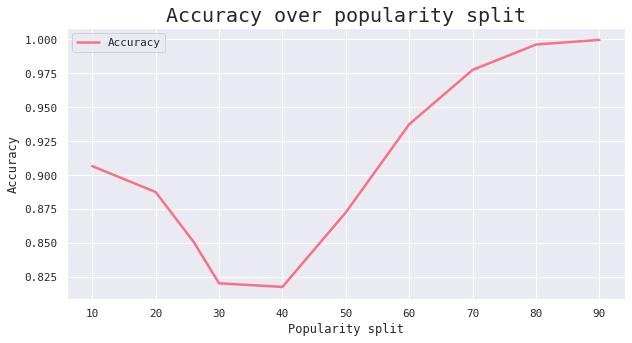

In [ ]:
#@title
def decisiontree(X_train, X_test, y_train, y_test, data_type='-'):
  clf = DecisionTreeClassifier(criterion="entropy", max_depth=10)

  # Train Decision Tree Classifer
  clf = clf.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(X_test)
  
  #plot_confusion_matrix(clf, X_test, y_test, labels=[0,1], cmap='Blues')  # 0 is not popular, 1 is popular

  # Model Accuracy, how often is the classifier correct?
  performance_DT = performance('Decision tree', data_type, y_test, y_pred)

  accuracy = sum(y_test == y_pred) / len(y_pred)
  
  return performance_DT, accuracy

# Train model on different splits
performance_DT_10, acc_10 = decisiontree(X_train, X_test, y_train_10, y_test_10, 'Split: 10')
performance_DT_20, acc_20  = decisiontree(X_train, X_test, y_train_20, y_test_20, 'Split: 20')
performance_DT_26, acc_26  = decisiontree(X_train, X_test, y_train_26, y_test_26, 'Median')
performance_DT_30, acc_30  = decisiontree(X_train, X_test, y_train_30, y_test_30, 'Split: 30')
performance_DT_40, acc_40  = decisiontree(X_train, X_test, y_train_40, y_test_40, 'Split: 40')
performance_DT_50, acc_50  = decisiontree(X_train, X_test, y_train_50, y_test_50, 'Split: 50')
performance_DT_60, acc_60  = decisiontree(X_train, X_test, y_train_60, y_test_60, 'Split: 60')
performance_DT_70, acc_70  = decisiontree(X_train, X_test, y_train_70, y_test_70, 'Split: 70')
performance_DT_80, acc_80  = decisiontree(X_train, X_test, y_train_80, y_test_80, 'Split: 80')
performance_DT_90, acc_90  = decisiontree(X_train, X_test, y_train_90, y_test_90, 'Split: 90')

# Create plot
accuracy = [acc_10,
            acc_20,
            acc_26,
            acc_30,
            acc_40,
            acc_50,
            acc_60,
            acc_70,
            acc_80,
            acc_90]
accuracy_plot(accuracy)

###3.3 Logistic Regression

Logistic Regression is a supervised model that does a binary classification based on some independent features. The model predicts the probability of the song being classified as popular or not poular and chooses the class with the highest probability. For this model both continuous and discrete data can be used.


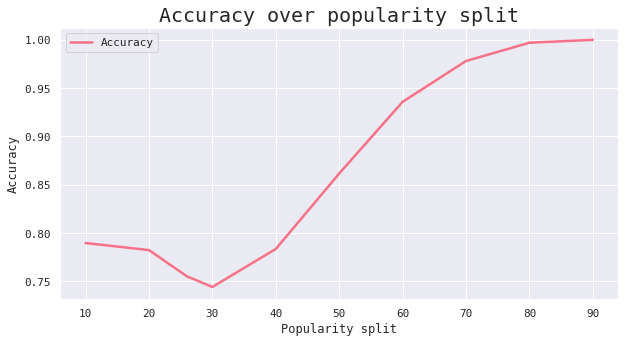

In [ ]:
#@title
def logregress(X_train, X_test, y_train, y_test, data_type='-'):
  clf = LogisticRegression(random_state=0).fit(X_train, y_train)
  y_pred_LogR = clf.predict(X_test)

  performance_LogR = performance('Logistic Regression', data_type, y_test, y_pred_LogR)

  accuracy = sum(y_test == y_pred_LogR) / len(y_pred_LogR)

  return performance_LogR, accuracy

# Train model on different splits
performance_LogR_10, acc_10 = logregress(X_train, X_test, y_train_10, y_test_10, 'Split: 10')
performance_LogR_20, acc_20 = logregress(X_train, X_test, y_train_20, y_test_20, 'Split: 20')
performance_LogR_26, acc_26 = logregress(X_train, X_test, y_train_26, y_test_26, 'Median')
performance_LogR_30, acc_30 = logregress(X_train, X_test, y_train_30, y_test_30, 'Split: 30')
performance_LogR_40, acc_40 = logregress(X_train, X_test, y_train_40, y_test_40, 'Split: 40')
performance_LogR_50, acc_50 = logregress(X_train, X_test, y_train_50, y_test_50, 'Split: 50')
performance_LogR_60, acc_60 = logregress(X_train, X_test, y_train_60, y_test_60, 'Split: 60')
performance_LogR_70, acc_70 = logregress(X_train, X_test, y_train_70, y_test_70, 'Split: 70')
performance_LogR_80, acc_80 = logregress(X_train, X_test, y_train_80, y_test_80, 'Split: 80')
performance_LogR_90, acc_90 = logregress(X_train, X_test, y_train_90, y_test_90, 'Split: 90')


# Create plot
accuracy = [acc_10,
            acc_20,
            acc_26,
            acc_30,
            acc_40,
            acc_50,
            acc_60,
            acc_70,
            acc_80,
            acc_90]
accuracy_plot(accuracy)

### 3.4 kNN Classifier

The kNN (or k-Nearest Neighbors) classifier is a model that assigns an observation to a class based on the most common class of the k-nearest neighbors. We plotted the training and testing accuracy as a function of k to decide which number of neighbors would be best to use.

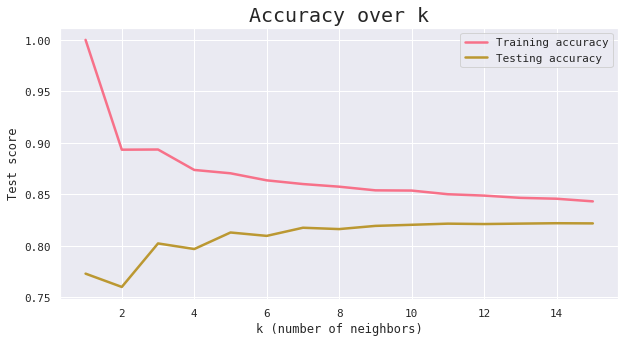

In [ ]:
#@title
def knn_neighbor(X_train, X_test, y_train, y_test):
  training_accuracy = [] 
  testing_accuracy = []

  K = range(1, 15+1)

  for k in K:
      clf = KNeighborsClassifier(n_neighbors=k)
      clf.fit(X_train, y_train)

      #print("Test set predictions: {}".format(clf.predict(X_test)))
      training_accuracy.append(clf.score(X_train, y_train))
      testing_accuracy.append(clf.score(X_test, y_test))
  # Create plot
  fig, ax = plt.subplots(figsize =(10, 5))
  ax.set(ylabel="Test score", xlabel="k (number of neighbors)")
  ax.set_title(label="Accuracy over k", fontsize=title_size)
  sns.lineplot(x=K, y=training_accuracy, label="Training accuracy", linewidth=2.5)
  sns.lineplot(x=K, y=testing_accuracy, label="Testing accuracy", linewidth=2.5)
  plt.legend()
  plt.show()

knn_neighbor(X_train, X_test, y_train_26, y_test_26)

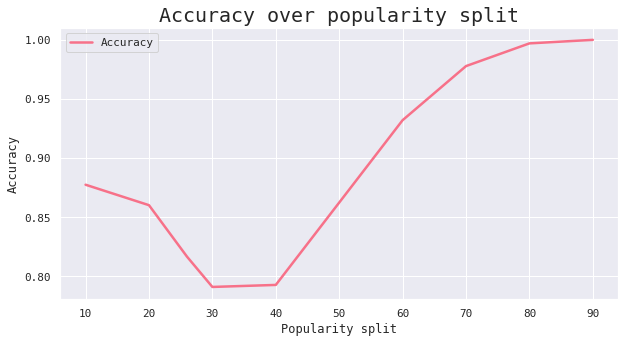

In [ ]:
#@title
def knn(X_train, X_test, y_train, y_test, data_type='-'):
  # Create kNN classifier with a number of neighbors that seems to be good (around 8)
  clf = KNeighborsClassifier(n_neighbors=8)
  clf.fit(X_train, y_train)
  pred = clf.predict(X_test)

  #plot_confusion_matrix(clf, X_test, y_test, labels=[0,1], cmap='Blues')  # 0 is not popular, 1 is popular

  performance_KNN = performance('kNN Classifier', data_type, y_test, pred) 

  accuracy = sum(y_test == pred) / len(pred)

  return performance_KNN, accuracy

# Train model on different splits
performance_KNN_10, acc_10 = knn(X_train, X_test, y_train_10, y_test_10, 'Split: 10')
performance_KNN_20, acc_20 = knn(X_train, X_test, y_train_20, y_test_20, 'Split: 20')
performance_KNN_26, acc_26 = knn(X_train, X_test, y_train_26, y_test_26, 'Median')
performance_KNN_30, acc_30 = knn(X_train, X_test, y_train_30, y_test_30, 'Split: 30')
performance_KNN_40, acc_40 = knn(X_train, X_test, y_train_40, y_test_40, 'Split: 40')
performance_KNN_50, acc_50 = knn(X_train, X_test, y_train_50, y_test_50, 'Split: 50')
performance_KNN_60, acc_60 = knn(X_train, X_test, y_train_60, y_test_60, 'Split: 60')
performance_KNN_70, acc_70 = knn(X_train, X_test, y_train_70, y_test_70, 'Split: 70')
performance_KNN_80, acc_80 = knn(X_train, X_test, y_train_80, y_test_80, 'Split: 80')
performance_KNN_90, acc_90 = knn(X_train, X_test, y_train_90, y_test_90, 'Split: 90')


# Create plot
accuracy = [acc_10,
            acc_20,
            acc_26,
            acc_30,
            acc_40,
            acc_50,
            acc_60,
            acc_70,
            acc_80,
            acc_90]
accuracy_plot(accuracy)

###3.5 Random Forest Classifier

A random forest is a collection of decision trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results. 

(C. Müller, A. & Guido, S., Intro to Machine Learning with Python, p. 83)

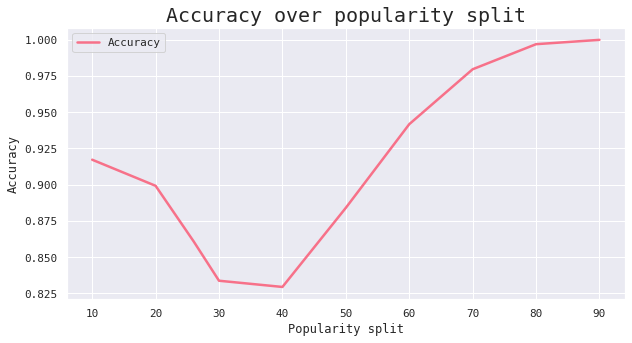

In [ ]:
#@title
def randomforest(X_train, X_test, y_train, y_test, data_type='-'):
  #Create a Gaussian Classifier
  clf = RandomForestClassifier(n_estimators=100, criterion='entropy')

  #Train the model using the training sets y_pred=clf.predict(X_test)
  clf.fit(X_train,y_train)

  y_pred = clf.predict(X_test)

  #plot_confusion_matrix(clf, X_test, y_test, labels=[0,1], cmap='Blues')  # 0 is not popular, 1 is popular

  performance_RFC = performance('Random Forest', data_type, y_test, y_pred)

  accuracy = sum(y_test == y_pred) / len(y_pred)

  return performance_RFC, accuracy

# Train model on different splits
performance_RFC_10, acc_10 = randomforest(X_train, X_test, y_train_10, y_test_10, 'Split: 10')
performance_RFC_20, acc_20 = randomforest(X_train, X_test, y_train_20, y_test_20, 'Split: 20')
performance_RFC_26, acc_26 = randomforest(X_train, X_test, y_train_26, y_test_26, 'Median')
performance_RFC_30, acc_30 = randomforest(X_train, X_test, y_train_30, y_test_30, 'Split: 30')
performance_RFC_40, acc_40 = randomforest(X_train, X_test, y_train_40, y_test_40, 'Split: 40')
performance_RFC_50, acc_50 = randomforest(X_train, X_test, y_train_50, y_test_50, 'Split: 50')
performance_RFC_60, acc_60 = randomforest(X_train, X_test, y_train_60, y_test_60, 'Split: 60')
performance_RFC_70, acc_70 = randomforest(X_train, X_test, y_train_70, y_test_70, 'Split: 70')
performance_RFC_80, acc_80 = randomforest(X_train, X_test, y_train_80, y_test_80, 'Split: 80')
performance_RFC_90, acc_90 = randomforest(X_train, X_test, y_train_90, y_test_90, 'Split: 90')


# Create plot
accuracy = [acc_10,
            acc_20,
            acc_26,
            acc_30,
            acc_40,
            acc_50,
            acc_60,
            acc_70,
            acc_80,
            acc_90]
accuracy_plot(accuracy)

### 3.6 Neural Network
This Neural Network consists of four dense layers and a dropout layer to prevent overfitting. Each dense layer uses ReLU activation. In the output layer, a sigmoid activation is used because we are dealing with a binary classifier. We use Adam optimizer and compile the model with binary cross entropy as loss and accuracy as metric. Typically it requires a validation set to define an ideal model, but in order to keep consistency in this project, we use only training set and test set. Again, different splits are used to test the performance. In practice, this model converges to its lowest loss after ca 200-400 iterations. We choose 100 iterations to speed up the process.

In [ ]:
#@title
def Dense_model():
    model = Sequential()

    model.add(layers.Dense(100, activation = 'relu',input_dim=14))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(30, activation = 'relu'))

    # The last layer is a linear layer
    model.add(layers.Dense(1, activation = 'sigmoid'))
    return model

def NN_model(X_train, X_test, y_train, y_test, data_type='-'):
    model_nn = Dense_model()
    model_nn.summary()
    adam = Adam(learning_rate=0.00001)
    model_nn.compile(loss=losses.binary_crossentropy, optimizer=adam, metrics=['accuracy'])
    logfile = model_nn.fit(X_train, y_train, epochs = 100, batch_size = 32)
    es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    y_pred_NN = model_nn.predict(X_test).flatten()
    y_pred_NN = np.int64(y_pred_NN>= 0.5)

    performance_NN = performance('Neural Network', data_type, y_test, y_pred_NN)
    accuracy = sum(y_test == y_pred_NN) / len(y_pred_NN)
    return performance_NN, accuracy, logfile

# Train model on different splits
#performance_NN_10, acc_10, logfile = NN_model(X_train, X_test, y_train_10, y_test_10, 'Split: 10')
#performance_NN_20, acc_20, logfile = NN_model(X_train, X_test, y_train_20, y_test_20, 'Split: 20')
performance_NN_26, acc_26, logfile = NN_model(X_train, X_test, y_train_26, y_test_26, 'Median')
#performance_NN_30, acc_30, logfile = NN_model(X_train, X_test, y_train_30, y_test_30, 'Split: 30')
#performance_NN_40, acc_40, logfile = NN_model(X_train, X_test, y_train_40, y_test_40, 'Split: 40')
#performance_NN_50, acc_50, logfile = NN_model(X_train, X_test, y_train_50, y_test_50, 'Split: 50')
#performance_NN_60, acc_60, logfile = NN_model(X_train, X_test, y_train_60, y_test_60, 'Split: 60')
#performance_NN_70, acc_70, logfile = NN_model(X_train, X_test, y_train_70, y_test_70, 'Split: 70')
#performance_NN_80, acc_80, logfile = NN_model(X_train, X_test, y_train_80, y_test_80, 'Split: 80')
#performance_NN_90, acc_90, logfile = NN_model(X_train, X_test, y_train_90, y_test_90, 'Split: 90')


# Create plot
#accuracy = [acc_10,
#            acc_20,
#            acc_26,
#            acc_30,
#            acc_40,
#            acc_50,
#            acc_60,
#            acc_70,
#            acc_80,
#            acc_90]

#accuracy_plot(accuracy)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_33 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 31        
Total params: 8,111
Trainable params: 8,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3487/3487 [==============================] - 6s 2ms/step - loss: 0.6782 - accuracy: 0.5896
Epoch 2/100
348

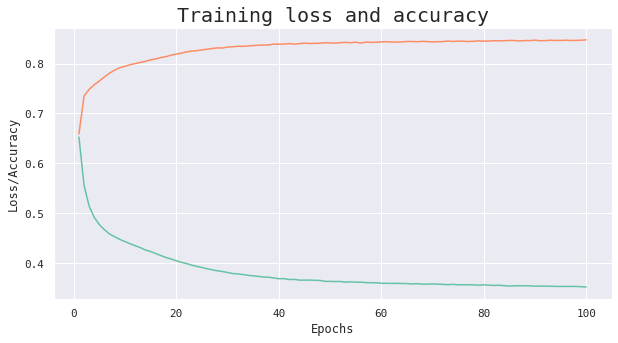

In [ ]:
#@title
# Plot the log
loss_values = logfile.history['loss']
accuracy_values = logfile.history['accuracy']
epochs = range(1, len(loss_values) + 1)

fig, ax = plt.subplots(figsize =(10, 5))

ax.plot(epochs, 
        loss_values, 
        color=(0.4, 0.7607843137254902, 0.6470588235294118), 
        label='Training loss') 

ax.plot(epochs, 
        accuracy_values, 
        color=(0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 
        label='Training accuracy') 

ax.set_title('Training loss and accuracy', fontsize=title_size)
ax.set(ylabel='Loss/Accuracy', xlabel='Epochs')
plt.show()

As you can see in the previous plots we would get over- or underfitting if we were to choose a split far from the median. We therefore wanted to compare three different splits in our final result to analyze the performance of them:

1. The dataset that is splitted at the median.

2. The dataset where we split at popularity = 50 and use undersampling to prevent over- or underfitting. 

3. The dataset that is splitted at the median with only the selected features from boruta and selectKbest. 

In [ ]:
# Naive Bayes Classifier
columns_numerical_selected = ['acousticness', 'danceability','energy', 'duration_ms', 'instrumentalness', 'valence', 'tempo', 'liveness', 'loudness', 'speechiness', 'year']
columns_categorical_selected = ['explicit']

performance_NB_down, _ = naivebayes(columns_numerical, columns_categorical, X_train_down, X_test, y_train_down, y_test_50, 'Undersampled')
performance_NB_selected, _ = naivebayes(columns_numerical_selected, columns_categorical_selected, X_train_selected, X_test_selected, y_train_26, y_test_26, 'Selected')

In [ ]:
# Decision tree
performance_DT_down, _ = decisiontree(X_train_down, X_test, y_train_down, y_test_50, 'Undersampled')
performance_DT_selected, _ = decisiontree(X_train_selected, X_test_selected, y_train_26, y_test_26, 'Selected')

In [ ]:
# Logistic regression
performance_LogR_down, _ = logregress(X_train_down, X_test, y_train_down, y_test_50, 'Undersampled')
performance_LogR_selected, _ = logregress(X_train_selected, X_test_selected, y_train_26, y_test_26, 'Selected')

In [ ]:
# kNN Classifier
performance_KNN_down, _ = knn(X_train_down, X_test, y_train_down, y_test_50, 'Undersampled')
performance_KNN_selected, _ = knn(X_train_selected, X_test_selected, y_train_26, y_test_26, 'Selected')

In [ ]:
# Random Forest Classifier
performance_RFC_down, _ = randomforest(X_train_down, X_test, y_train_down, y_test_50, 'Undersampled')
performance_RFC_selected, _ = randomforest(X_train_selected, X_test_selected, y_train_26, y_test_26, 'Selected')

In [ ]:
# Neural Network
performance_NN_down, _, _ = NN_model(X_train_down, X_test, y_train_down, y_test_50, 'Undersampled')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_37 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 31        
Total params: 8,111
Trainable params: 8,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1093/1093 [==============================] - 2s 2ms/step - loss: 0.7060 - accuracy: 0.4982
Epoch 2/100
109

# Results

In [ ]:
#@title
model_performance = pd.concat([performance_NB_26, 
                               performance_NB_down, 
                               performance_NB_selected, 
                               performance_DT_26, 
                               performance_DT_down, 
                               performance_DT_selected, 
                               performance_LogR_26, 
                               performance_LogR_down, 
                               performance_LogR_selected, 
                               performance_KNN_26, 
                               performance_KNN_down, 
                               performance_KNN_selected, 
                               performance_RFC_26, 
                               performance_RFC_down, 
                               performance_RFC_selected,
                               performance_NN_26, 
                               performance_NN_down])

model_performance = model_performance.sort_values('Accuracy', ascending=False)  # Sort values by accuracy
model_performance.index = range(len(model_performance))  # Get unique indexes

model_performance

Model      Datatype  Accuracy  ...    Recall  f1-score  support
0         Random Forest      Selected  0.861505  ...  0.826059  0.859420    24537
1         Random Forest      Selected  0.861505  ...  0.898766  0.863529    23342
2         Random Forest        Median  0.860795  ...  0.899752  0.863055    23342
3         Random Forest        Median  0.860795  ...  0.823736  0.858460    24537
4         Decision tree      Selected  0.850811  ...  0.889984  0.853299    23342
5         Decision tree      Selected  0.850811  ...  0.813547  0.848238    24537
6         Decision tree        Median  0.850623  ...  0.812895  0.847972    24537
7         Decision tree        Median  0.850623  ...  0.890284  0.853184    23342
8        Neural Network        Median  0.849621  ...  0.824388  0.848917    24537
9        Neural Network        Median  0.849621  ...  0.876146  0.850318    23342
10       kNN Classifier      Selected  0.827816  ...  0.831334  0.824797    23342
11       kNN Classifier      Selected  0.827816  ...  0.824469  0.830733    24537
12       kNN Classifier        Median  0.816329  ...  0.811468  0.819113    24537
13       kNN Classifier        Median  0.816329  ...  0.821438  0.813457    23342
14        Random Forest  Undersampled  0.777042  ...  0.769956  0.852963    40214
15        Random Forest  Undersampled  0.777042  ...  0.814220  0.539016     7665
16        Decision tree  Undersampled  0.775309  ...  0.776769  0.853097    40214
17        Decision tree  Undersampled  0.775309  ...  0.767645  0.522419     7665
18       kNN Classifier  Undersampled  0.761127  ...  0.765132  0.843275    40214
19       kNN Classifier  Undersampled  0.761127  ...  0.740117  0.498003     7665
20  Logistic Regression      Selected  0.755613  ...  0.784509  0.757869    23342
21  Logistic Regression      Selected  0.755613  ...  0.728125  0.753315    24537
22  Logistic Regression        Median  0.755237  ...  0.728329  0.753081    24537
23  Logistic Regression        Median  0.755237  ...  0.783523  0.757356    23342
24          Naive Bayes      Selected  0.748157  ...  0.831591  0.763011    23342
25          Naive Bayes      Selected  0.748157  ...  0.668786  0.731316    24537
26          Naive Bayes        Median  0.748031  ...  0.668745  0.731206    24537
27          Naive Bayes        Median  0.748031  ...  0.831377  0.762874    23342
28  Logistic Regression  Undersampled  0.745901  ...  0.776647  0.494600     7665
29  Logistic Regression  Undersampled  0.745901  ...  0.740041  0.830288    40214
30       Neural Network  Undersampled  0.741411  ...  0.727657  0.825386    40214
31       Neural Network  Undersampled  0.741411  ...  0.813568  0.501831     7665
32          Naive Bayes  Undersampled  0.679379  ...  0.845662  0.457849     7665
33          Naive Bayes  Undersampled  0.679379  ...  0.647685  0.772386    40214

[34 rows x 10 columns]

---
# Discussion

### The pre-processing of the data

**Split by popularity**

Initially, our aim was to keep popularity in its scale between 0-100 in order to not risk losing important information. After discussion with our supervisor André, we got the recommendation to simplify our problem by dividing the popularity into two or three classes since the project already was so tough. This division of the popularity quickly became one of the greatest issues during this project. From one perspective, the reasonable way to split it seemed to be in the middle of the scale (50). Although, from this we would get misleading accuracy scores due to overfitting caused by the popularity not being normally distributed. We found two methods to handle this: either by undersampling of the data, or by instead using the median as the limit for the split, which would both get us equally sized classes. In the end we decided to plot how the models accuracy would change when we used different splits of the data to see where we get overfitting and therefore we changed the "original" split from 50 to the median, 26. We also did the 50 split with undersampling to compare. 

**Split by year**

We also decided to split the training and testing set by year since the distribution of songs was not equal per year. The features also changed a lot over time.

**Why did we keep year as a feature?**

This topic was vividly discussed in the group and together with our supervisor. The issue was whether or not we shoud keep the year in the data. The argument for keeping year was that the Spotify popularity feature is calculated based on the popularity right now, not over time. Therefore year will be a very important feature in predicting the popularity. The argument for not keeping the year feature was that year is not an acoustic feature and the model will be biased against year even if the acoustic features would be similar to the ones of popular songs today. In the end we decided to keep year since popularity and year is very correlated and because of the above mentioned about Spotify's calculation of the popularity feature.


### The unsupervised learning methods and visualization of data

The main conclusions from our unsupervised learning methods and visualizing of the data was that **year**, **loudness**, **dancability** and **energy** are positively correlated with popularity and **acousticness**, **instrumentalness**, **speechiness** have negative correlation. These features was also selected by both boruta and selectKbest which therefore confirmed that these features might be the most important related to popularity.


### The supervised methods

Random forest, neural network and decision tree gave us the best accuracy score. We also saw that the different datasets versions affected the results. 
For random forest, decision tree and kNN, the selected features performed marginally better than the original median split. 
The original median split dataset seems to outperform the 50 split undersampled dataset. This could be because when we perform undersampling we lose a lot of data which could make the models perform worse. Undersampling is therefore not a preferred way to handle skewedness in the data in this case.


### Do we have all it takes to know what makes a hit song?

No. What makes a song popular is very complex and involve much more than the features we have investigated during this project. Although, we have gained some knowledge about some features that seems to be trending in popular songs. We can also see that newer songs seems to have a greater probability of being popular today according to the Spotify popularity measure. 

### What could improve?
- **More data and features** are needed to get a more realistic model. Melody and lyrics should be taken into consideration, or features like genre, timbre, how much is invested into marketing of a song, how much it has been shared in social media, data from other sources than Spotify, etc.
- **Another measure of popularity** than Spotify's? Since we didn't have insight in exactly how Spotify's popularity feature was calculated it might have affected the results negatively.
- A **validation dataset** should be used to improve our models to give an unbiased estimate of the performance of the model in order to being able to fine-tune, compare and select final models. We could probably also get more correct results when choosing the hyper-parameters if we had **used the training dataset instead of the testing dataset**.
- **Visualize the final results of the models** in a better way, for instance by using explainability layers and confusion matrices.
- Find **a better solution for how to remove duplicates**: e.g. keep the one with the highest popularity.
- Look more into **augmenting the audio data** (which would take more time than this project allows).
- **Log scale or z-score normalization of some of the data** to better fit methods that assume normal distribution or benefit from other types of scaling.
- We would have liked to **develop the neural network further**, but since this was such a complex algorithm we chose to use it in a simplified manner.

- ...but since this was such a complex problem we focused more on the investigative part.


# Acknowledgments

In the beginning of the project there were only Elin, Filippa and Linnéa in the project group, therefore they planned and chose which dataset to use and which problem formulation to move forward with. Later on Huanchen joined the group and got involved in the process. The group had some initial meetings where we planned how to approach the problem and decided to do as much as possible together, so everyone could have great knowledge on all parts of the project. Since Huanchen had a different schedule than the rest of the group he couldn't join all meetings, so he was assigned to be responsible for some own parts (mentioned below). The rest of the group has done most of the other work together, such as the written report, pre-processing of the data, the group presentation, the data visualization and the final conclusions.

Huanchen Cai

- The Boruta feature selection
- The neural network model
- The written discussion about the neural network model

Elin Granstedt

- The naive Bayes model
- The logistic regression model

Linnéa Gustafsson

- The scatter matrix
- The principal component analysis

Filippa Leuckfeld

- The decision tree model
- The random forest model


# Final meme

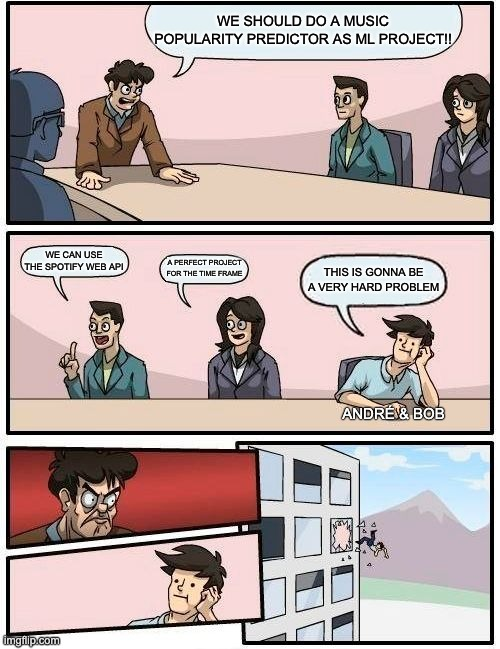


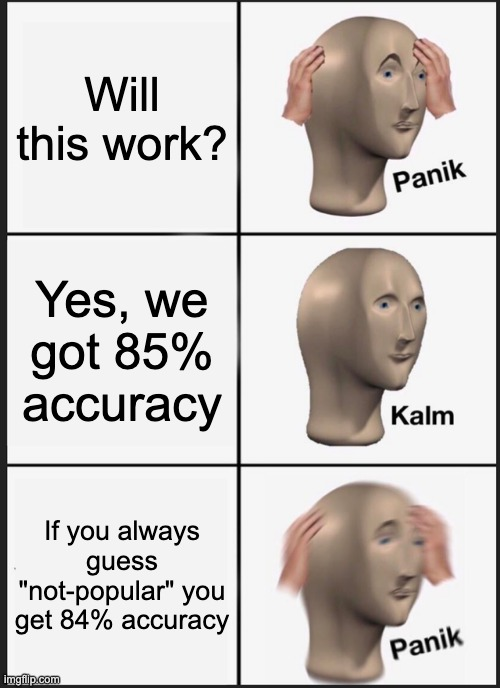